# Intro

This is a notebook summarizing experiments run in Summer 2024 by Nick Huang investigating the various use cases and performance of Prediction Powered Inference (PPI).

The equation for PPI variance, which is a key focus is given by 
\begin{equation}
    \sqrt{\frac{\hat{\sigma}_{f - \hat{Y}}}{n} + \frac{\hat{\sigma}_{F}}{N}} 
\end{equation}

Recall that the variance of the classical estimator is given by

\begin{equation}
    \sqrt{\frac{\hat{\sigma}_{\hat{Y}}}{n}}
\end{equation}

## Experiment 1

The point of experiment 1 is to be a baseline experiment of when PPI performs well. We have 3 distributions: the training distribution, the labelled (gold) distribution, and the unlabelled (ppi) distribution. In this experiment, we set all 3 distributions to be the same, and we also observe what happens when the data becomes noisier and noisier. As well, we compare what happens when we use a good/bad model, and how PPI performs compared to just classical confidence interval generation.

### Setting 1

Here we have a very idealized experiment, $X \sim Gamma(2, 2)$, and $Y = 4X + \varepsilon$. Here $\varepsilon \sim N(0, m^2 * \alpha * \beta * \frac{1 - \rho}{\rho})$, in this case, $m = 4, \alpha = 2, \beta = 2$, and $\rho$ is varied so that $Corr(X, Y) = \rho$.

We fit a linear regression model, in this scenario we expect PPI to permform very well, and should be a big improvement over classical methods.

In the following example, we set $n = 128, 16, N = 10000$, in which case, the second term in $(1)$ is irrelevant.

<font color="red">List of configs to re-run/edit</font>

- Under linear reg/linear data
    
    - n = 16

    - n = 128

- Under linear reg/wtf data

    - n = 16

    - n = 128

- Under XGB/wtf data

    - n = 16

    - n = 128

<font color="blue"> Should be done now </font>

In [2]:
# Imports

import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import ppi
import ppi_py
import scipy.stats as stats
import pandas as pd
import ml_models as ml
import distributions as dist

import yaml
import os
import sys
import argparse
import plotting
import copy

c:\Users\Ziyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As an example, we will show what happens when $\rho = 0.5$, and fit a linear regression model to see how well the model performs. 

In [3]:
# Load file

config = "../configs/Experiment_1_new/128g_l_reg.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

def test(config):
    rho_vals = [.5]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

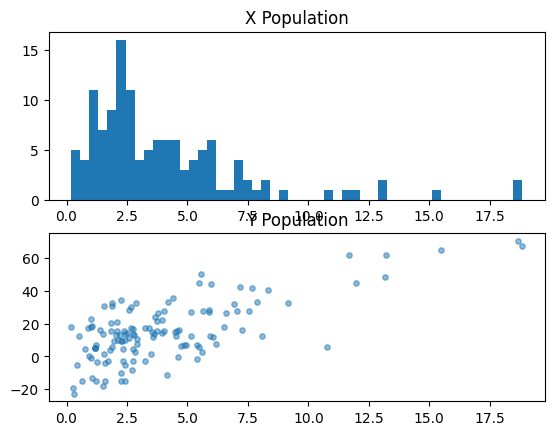

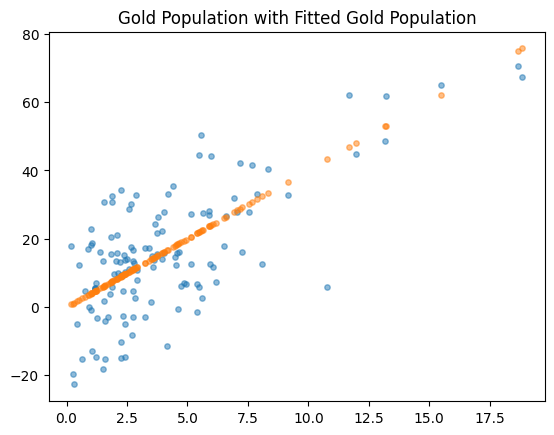

In [12]:
# Visualize

test(config)

As we can see, the model fits reasonably well. The following is a graph that shows the Widths generated by various other methods.

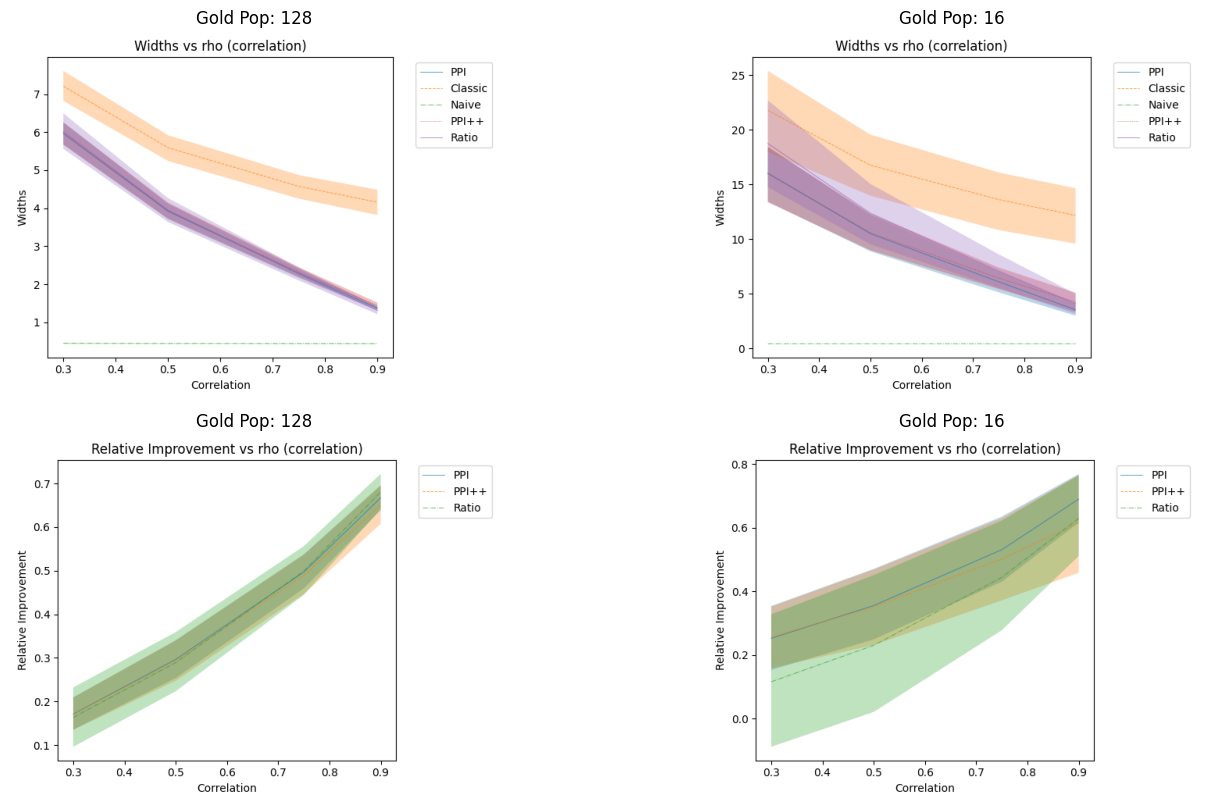

In [24]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_128 = '../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/plots/widthsplotwithratio.png'
gold_16 = '../experiments/Experiment_1_new/16g_l_reg_2024-08-13-23-12-17/plots/widthsplotwithratio.png'
gold_128_ri = '../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/plots/relativeimprovementwithratio.png'
gold_16_ri = '../experiments/Experiment_1_new/16g_l_reg_2024-08-13-23-12-17/plots/relativeimprovementwithratio.png'

# Display the PNG file
img_128 = plt.imread(gold_128)
img_16 = plt.imread(gold_16)
im_128_ri = plt.imread(gold_128_ri)
im_16_ri = plt.imread(gold_16_ri)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_ri)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_ri)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


In this idealized scenario, it is clear that PPI provides a very large performance boost, and the performance boost gets much greater as the model becomes easier to fit. No surprises here.

If you look carefully, "Naive Widths" performs very well, which refers to imputing the values and treating those values as true data, then constructing a confidence interval as usual.

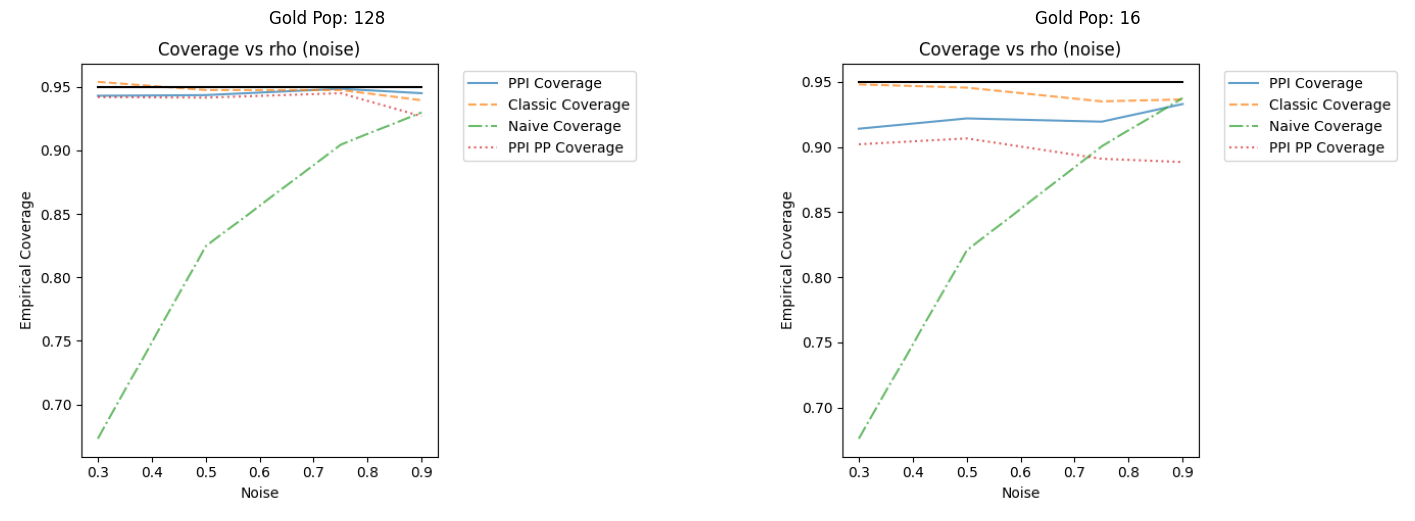

In [48]:
# Coverage plots

# Set the variable to the path of the PNG file
gold_128_cov = '../experiments/Experiment_1/reg_lin_128_2024-07-30-00-07-14/plots/coverageplot.png'
gold_16_cov = '../experiments/Experiment_1/reg_lin_16_2024-07-30-00-06-38/plots/coverageplot.png'

# Display the PNG file
img_128_cov = plt.imread(gold_128_cov)
img_16_cov = plt.imread(gold_16_cov)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_cov)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_cov)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

Unsurprisingly, since imputation gives biased results if the ML model is biased at all, and this method does not follow correct statistical assumptions, the confidence intervals generated, while small, don't often cover the true value.

### Setting 2

In this case, we change the distribution of $X \sim N(0, 4)$, however in this case, we set $Y = 3 * \sin (X) + \exp(X / 8) + \varepsilon$. Here $\varepsilon \sim N(0, \frac{\rho}{2})$. As such, the relationship is non symmetric, and highly non-linear. 

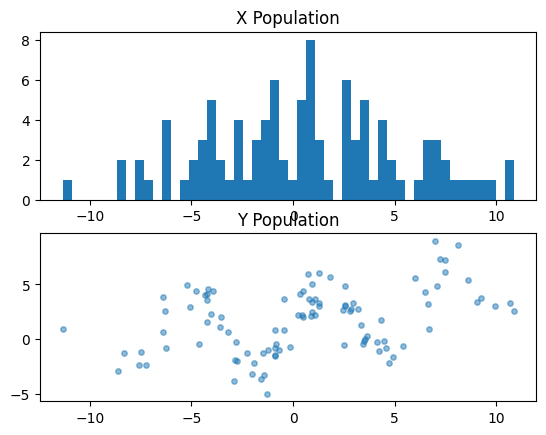

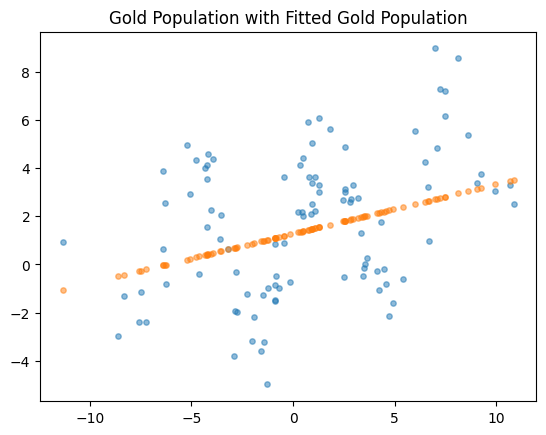

In [7]:
# Visualize setting 2

config2 = "../configs/Experiment_1_new/128g_nl_reg.yaml"
with open(config2, 'r') as stream:
    config2 = yaml.safe_load(stream)

def test2(config):
    rho_vals = [.4]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        pop_config['x_population']['size'] = 100
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

test2(config2)

As we can see here, we do not expect PPI to have much benefit over classical methods.

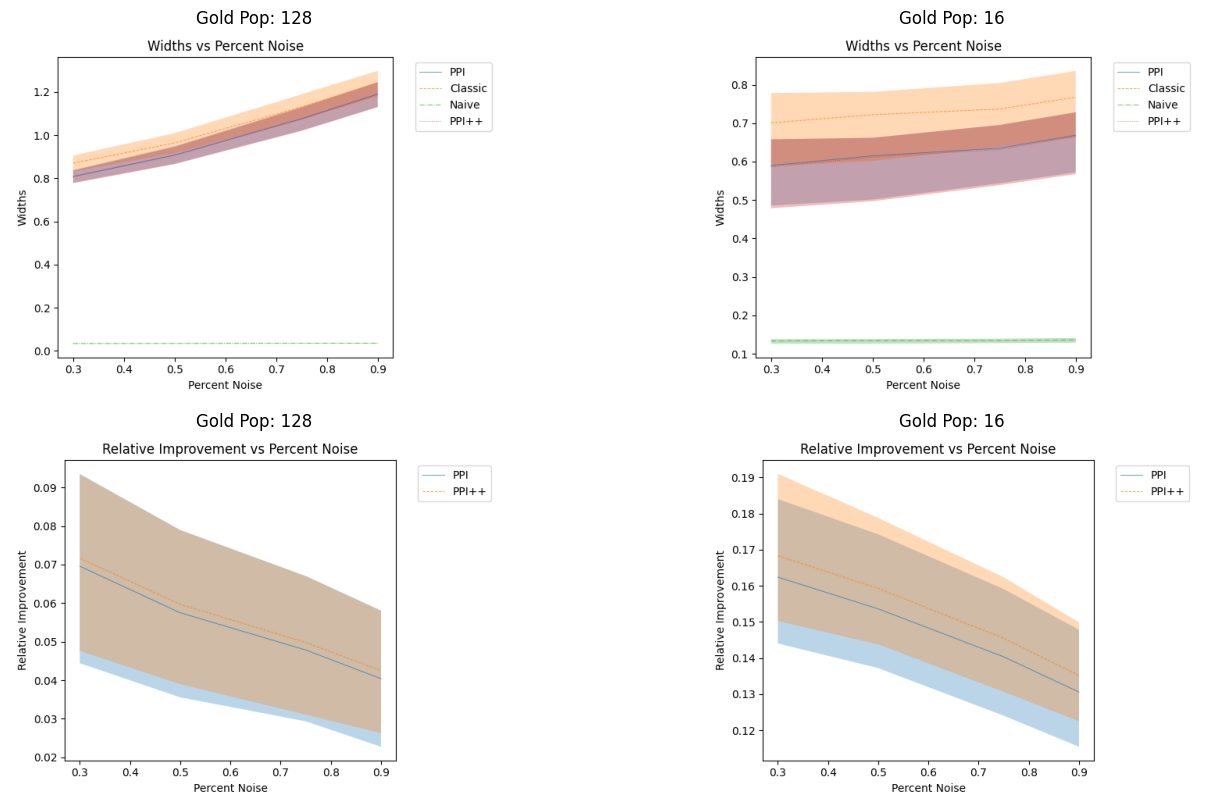

In [47]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_16_nl = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-13-23-13-01/plots/widthsplot.png'
gold_128_nl = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/widthsplot.png'
gold_16_nl_ri = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-13-23-13-01/plots/relativeimprovement.png'
gold_128_nl_ri = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/relativeimprovement.png'

# Display the PNG file
img_128_nl = plt.imread(gold_128_nl)
img_16_nl = plt.imread(gold_16_nl)
im_128_nl_ri = plt.imread(gold_128_nl_ri)
im_16_nl_ri = plt.imread(gold_16_nl_ri)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128_nl)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16_nl)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_nl_ri)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_nl_ri)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


No surprises here, PPI provides little to no benefit. We can also see what happens to how often imputation covers the true value is a very poorly fitted model.

In [49]:
# Coverage plots, setting 2

# Set the variable to the path of the PNG file
gold_128_cov_nl = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/coverageplot.png'
gold_16_cov_nl = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-13-23-13-01/plots/coverageplot.png'

# Display the PNG file
img_128_cov_nl = plt.imread(gold_128_cov_nl)
img_16_cov_nl = plt.imread(gold_16_cov_nl)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_cov_nl)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_cov_nl)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/Experiment_1/128g_nl_reg_2024-08-13-23-13-23/plots/coverageplot.png'

Naturally then, one might one to replace our poorly fitted linear regression model, with another better function appoximator. In this case, we will use XGBoost. 

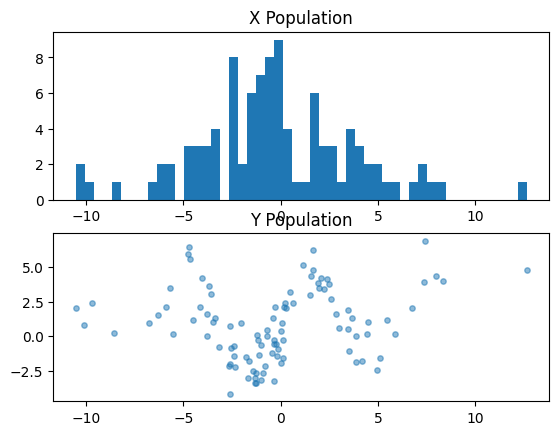

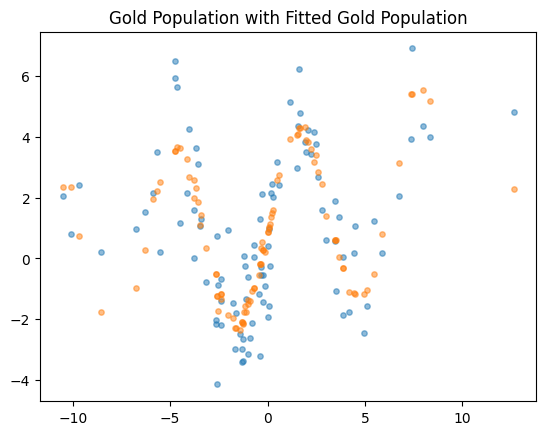

In [13]:
config3 = "../configs/Experiment_1_new/128g_nl_xgb.yaml"
with open(config3, 'r') as stream:
    config3 = yaml.safe_load(stream)

test2(config3)

From our visualization, XGBoost fits the data quite well. We would then expect PPI to perform well and give a significant reduction in width size.

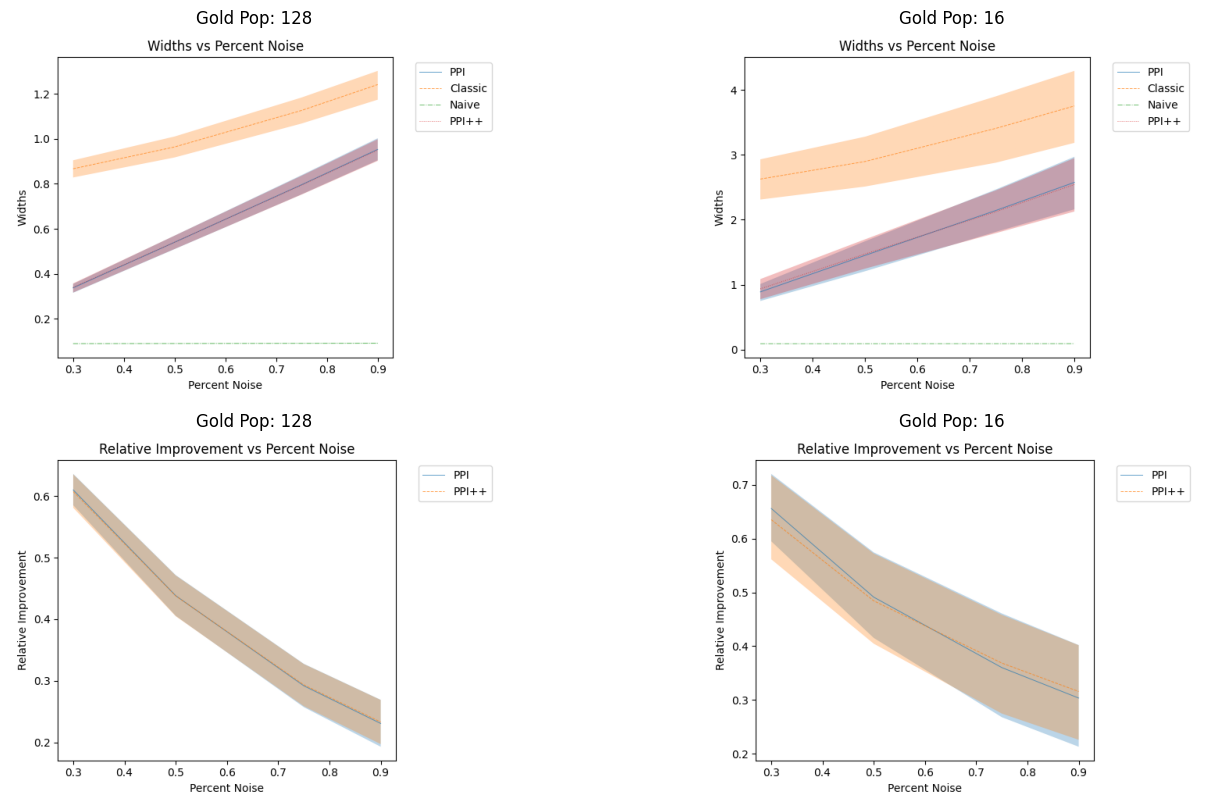

In [28]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_16_nl_xgb = '../experiments/Experiment_1_new/16g_nl_xgb_2024-08-13-21-02-12/plots/widthsplot.png'
gold_128_nl_xgb = '../experiments/Experiment_1_new/128g_nl_xgb_2024-08-13-21-21-16/plots/widthsplot.png'
gold_16_nl_ri_xgb = '../experiments/Experiment_1_new/16g_nl_xgb_2024-08-13-21-02-12/plots/relativeimprovement.png'
gold_128_nl_ri_xgb = '../experiments/Experiment_1_new/128g_nl_xgb_2024-08-13-21-21-16/plots/relativeimprovement.png'

# Display the PNG file
img_128_nl_xgb = plt.imread(gold_128_nl_xgb)
img_16_nl_xgb = plt.imread(gold_16_nl_xgb)
im_128_nl_ri_xgb = plt.imread(gold_128_nl_ri_xgb)
im_16_nl_ri_xgb = plt.imread(gold_16_nl_ri_xgb)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128_nl_xgb)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16_nl_xgb)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_nl_ri_xgb)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_nl_ri_xgb)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

## Experiment 2

In this experiment, we will investigate what happens when we apply the problem of distributional shift to the problem. Recall in the previous experiment, the distribution of the training, gold, unlabelled data are all the same. In this case we take $P_X^t \neq P_X^g = P_X^u$, however, in all three distributions, we keep the same probability distribution $P_{Y|X}$. That is, for any point $x$ that is near the training distribution, we expect good inference results. 

On the other hand, if we have a complicated relationship, that is difficult to infer accurately on, we expect as the distribution shifts further and further away from the training data, performance will become worse and worse.


<font color="red"> List of things to rerun </font>

Remove Gamma(4, 4) (leave to the next experiment)

- Linear data

    - 1k training clip

    - 1k training noclip

- Non-linear data

    - 1k training clip

    - 1k training noclip

    - 50k training clip
    
    - 50k training noclip

    - 1k training clip xgb

    - 1k training noclip xgb

    - 50k training clip xgb
    
    - 50k training noclip xgb

<font color="green"> Before running more training, check distribution/histogram of distribution with 100k/1m training data, see if necessary </font>

### Setting 1

#### Near perfect model, linear relationship

As a best case scenario, suppose $Y = 4X + \varepsilon$, $X^t \sim Gamma(2, 2)$, and $Y = 4X + \varepsilon$. Here $\varepsilon \sim N(0, m^2 * \alpha * \beta * \frac{1 - \rho}{\rho})$ as in, in experiment 1. Here, we set $\rho = 0.75$

We will look at a fair number of distributions, with

$X_0 \sim Gamma(2, 2)$ (Base case) 

$X_1 \sim Gamma(2, 3)$ 

$X_2 \sim Gamma(2, 4)$ 

$X_3 \sim Gamma(3, 2)$ 

$X_4 \sim Gamma(4, 2)$ 

$X_5 \sim Gamma(3, 3)$ 

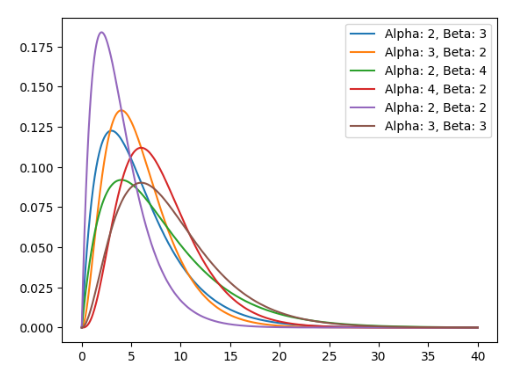

In [42]:
# The distribution plots

# Set the variable to the path of the PNG file

dist_plot_1 = "../experiments/Experiment_2_new/1kt_c_lin_reg_2024-08-14-02-43-26/plots/distplots.png"

# Display the PNG file

img_dist_plot_1 = plt.imread(dist_plot_1)
plt.imshow(img_dist_plot_1)
plt.axis('off')
plt.show()


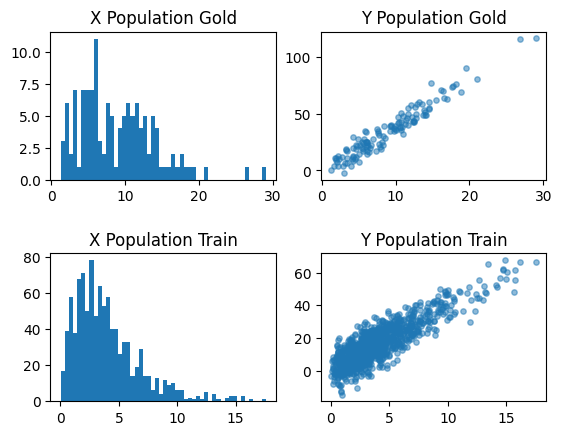

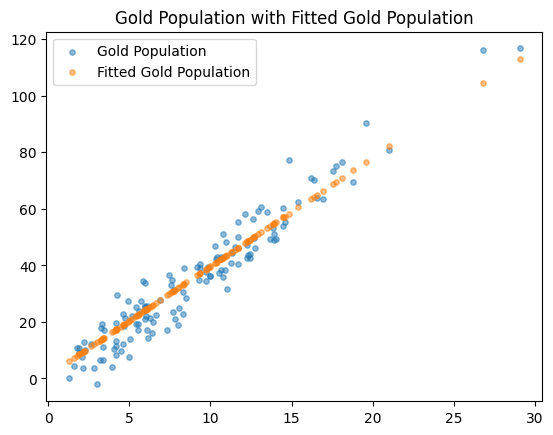

In [33]:
# Visualize the two distributions

def test3(config):
    rho_vals = [.75]
    pop_config = config['experiment']['parameters']['gold_population']
    train_config = config['experiment']['parameters']['training_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        train_config['y_population']['rho'] = rho

        pop_config['x_population']['alpha'] = 3
        pop_config['x_population']['beta'] = 3

        x_gold, y_gold = dist.sample_population(pop_config)

        ml_config = config['experiment']['model']

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the x population and the y population of both the gold and train populations
        fig, ax = plt.subplots(2, 2)
        ax[0, 0].hist(x_gold, bins=50)
        ax[0, 0].set_title("X Population Gold")
        ax[0, 1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[0, 1].set_title("Y Population Gold")
        ax[1, 0].hist(x_train, bins=50)
        ax[1, 0].set_title("X Population Train")
        ax[1, 1].scatter(x_train, y_train, alpha=0.5, s=15)
        ax[1, 1].set_title("Y Population Train")

        # put some vertical space between the plots
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.legend(["Gold Population", "Fitted Gold Population"])
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

config4 = "../configs/Experiment_2_new/1kt_nc_lin_reg.yaml"

with open(config4, 'r') as stream:
    config4 = yaml.safe_load(stream)

test3(config4)

In this case, we have opted for a small training sample, where the size of the training data is only 1000. However, in this case the training data will see *most* of the inference data, in both the gold population and the unlabelled population. However, since the performance is very strong with the model, PPI will perform well on any distribution of $X^t$ so long as it has reasonable overlap with the distribution of $X^g$.

Since the model fits nearly perfectly, we expect performance to be the same, no matter what $X^g$ distribution, as there is considerable overlap between the training and inference population, the performance of PPI should not change much, since the model should perform around the same.

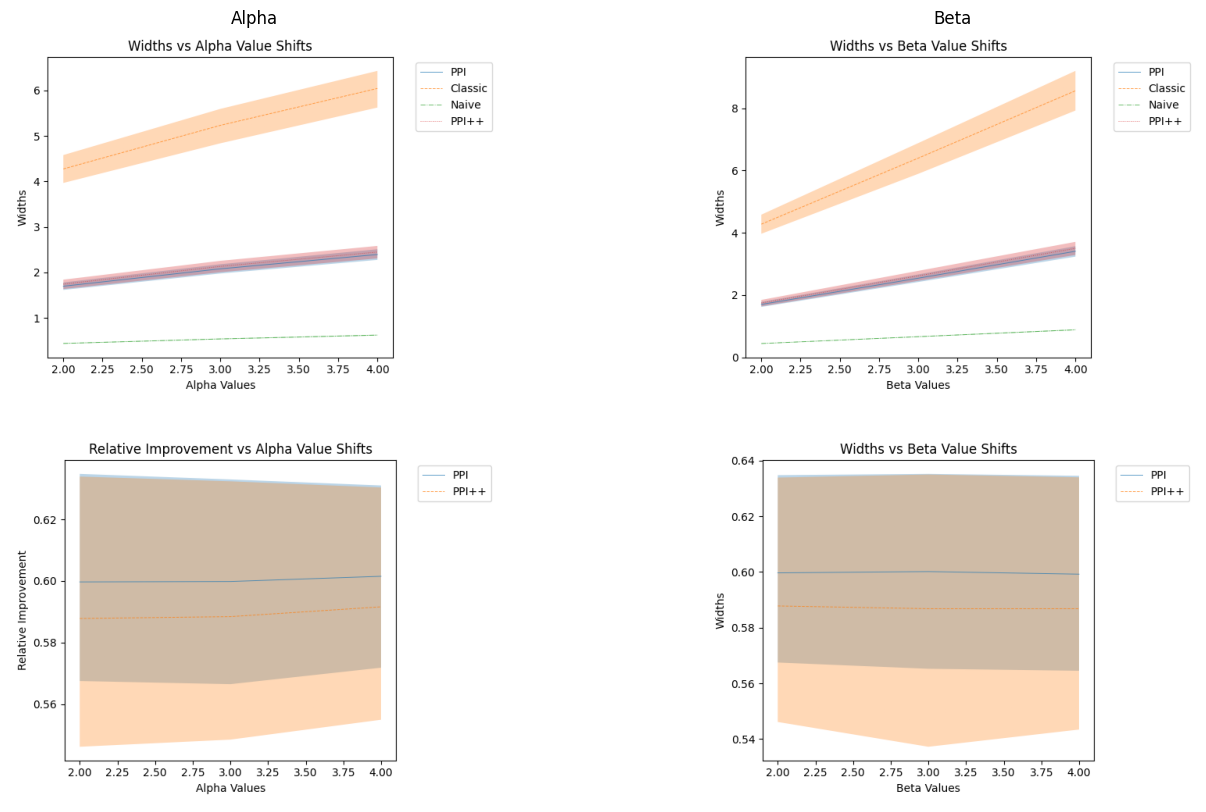

In [30]:
# Display the widths plots

# Set the variable to the path of the PNG file
alpha_width = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/widths_alpha_shifts.png'
beta_width = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/widths_beta_shifts.png'
alpha_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_alpha_shifts.png'
beta_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_beta_shifts.png'

# Display the PNG file
img_alpha_width = plt.imread(alpha_width)
img_beta_width = plt.imread(beta_width)
img_alpha_ri = plt.imread(alpha_ri)
img_beta_ri = plt.imread(beta_ri)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_alpha_width)
ax[0, 0].axis('off')
ax[0, 0].set_title('Alpha')
ax[0, 1].imshow(img_beta_width)
ax[0, 1].axis('off')
ax[0, 1].set_title('Beta')
ax[1, 0].imshow(img_alpha_ri)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_beta_ri)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


As expected, the relative improvement is constant, the only reason widths change at all is dependent on the variance of the distribution. For the sake of completion, let's take a look at the relative improvement with respect to Wasserstein Distance/Total Variation Distance from the initial distribution

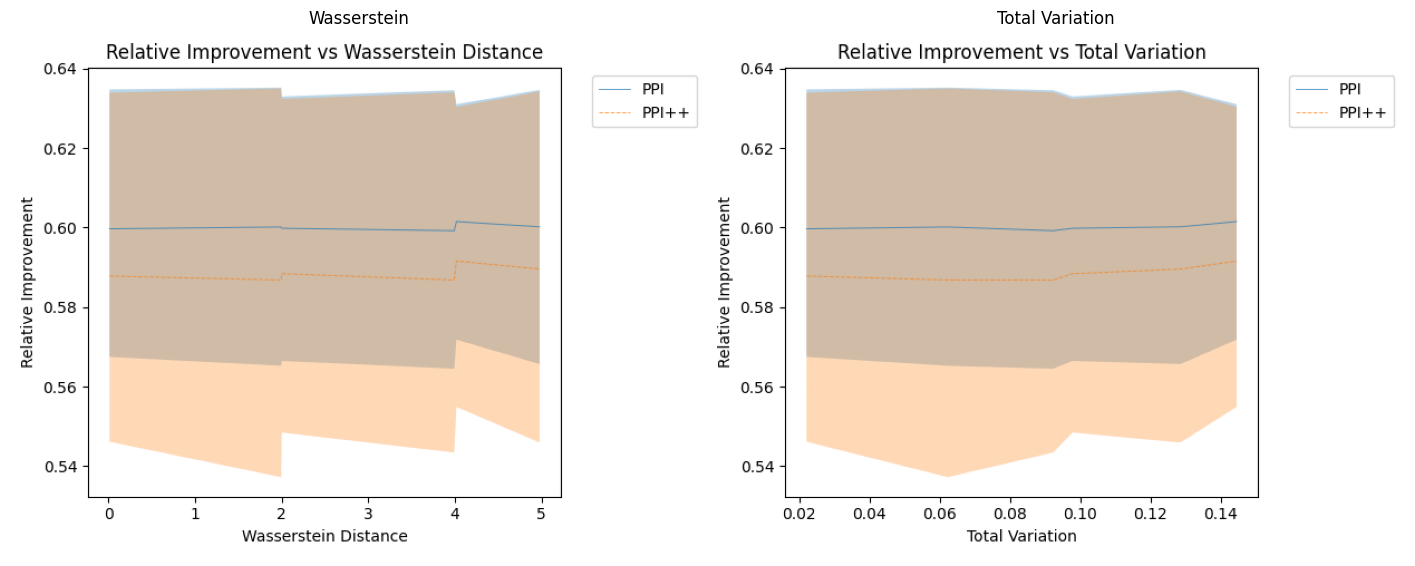

In [31]:
# Display the widths plots

# Set the variable to the path of the PNG file
wass_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_improvement_wass.png'
tv_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_improvement_tv.png'

# Display the PNG file
img_wass_ri = plt.imread(wass_ri)
img_tv_ri = plt.imread(tv_ri)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_wass_ri)
ax[0].axis('off')
ax[0].set_title('Wasserstein')
ax[1].imshow(img_tv_ri)
ax[1].axis('off')
ax[1].set_title('Total Variation')


# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


A note on clipping: Since the performance is so good, clipping really doesn't make a difference.

### Setting 2.2

#### Non-linear data, difficult fit

In this setting, we will reuse the conditional distribution of $Y$ by setting $Y = 3 \sin(X) + \exp(X/6) + \varepsilon$. To illustrate the relationship this time, we will take a look at the conditional distribution of $Y$ for a large range.

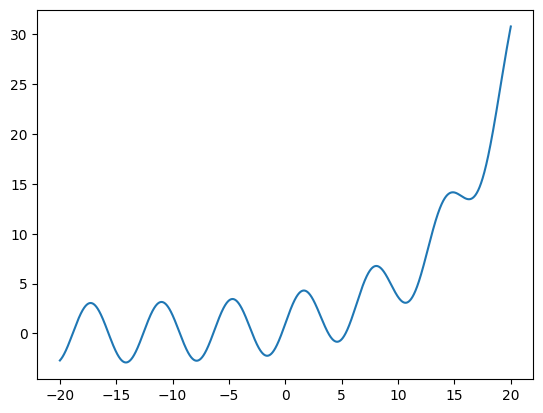

In [32]:
# Perfect distribution plot

x = np.linspace(-20, 20, 10000)
y = 3 * np.sin(x) + np.exp(x/6)

plt.plot(x, y)
plt.show()

In this setting, we will also be taking the $X$ distribution to be variations of the normal distribution. We set the training distribution to be $X \sim N(0, 4)$. We will be varying the distributions of $X$ to be 

- $X_0 \sim N(0, 4)$

- $X_1 \sim N(2, 4)$

- $X_2 \sim N(-2, 4)$

- $X_3 \sim N(4, 4)$

- $X_4 \sim N(-4, 4)$

- $X_5 \sim N(0, 5)$

- $X_6 \sim N(0, 6)$

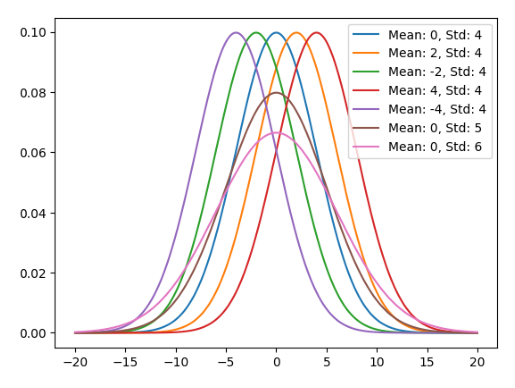

In [43]:
# Display the distribution plots

dist_plot_2 = "../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-14-04-06-06/plots/distplots.png"

# Display the PNG file

img_dist_plot_2 = plt.imread(dist_plot_2)
plt.imshow(img_dist_plot_2)
plt.axis('off')
plt.show()

Fitting becomes much harder therefore.

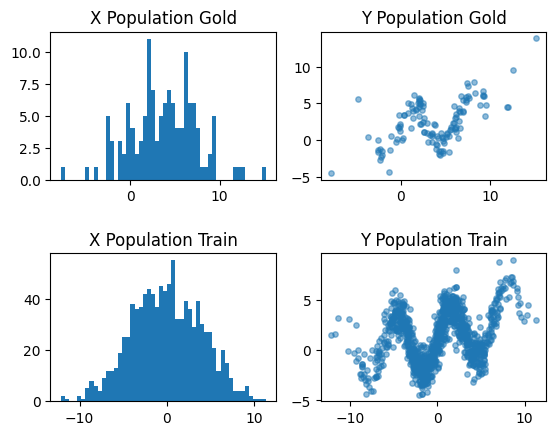

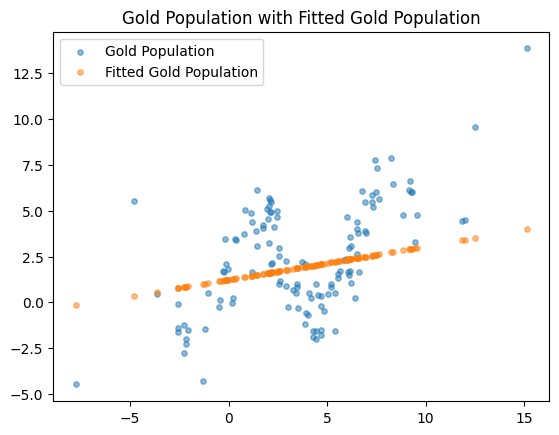

In [45]:
# Visualize setting 2.2

config5 = "../configs/Experiment_2_new/1kt_nc_nonlin_reg.yaml"

with open(config5, 'r') as stream:
    config5 = yaml.safe_load(stream)

def test4(config):
    rho_vals = [.4]
    pop_config = config['experiment']['parameters']['gold_population']
    train_config = config['experiment']['parameters']['training_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        train_config['y_population']['rho'] = rho

        pop_config['x_population']['mean'] = 4
        pop_config['x_population']['std'] = 4

        x_gold, y_gold = dist.sample_population(pop_config)

        ml_config = config['experiment']['model']

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the x population and the y population of both the gold and train populations
        fig, ax = plt.subplots(2, 2)
        ax[0, 0].hist(x_gold, bins=50)
        ax[0, 0].set_title("X Population Gold")
        ax[0, 1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[0, 1].set_title("Y Population Gold")
        ax[1, 0].hist(x_train, bins=50)
        ax[1, 0].set_title("X Population Train")
        ax[1, 1].scatter(x_train, y_train, alpha=0.5, s=15)
        ax[1, 1].set_title("Y Population Train")

        # put some vertical space between the plots
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.legend(["Gold Population", "Fitted Gold Population"])
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

test4(config5)